<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
############################################
## This script will simulate data from known statistical distirbutions; then estimate GAN and sample from it
## march 7 4pm hhh
## Authors: Betty and Chris

## Date: February 2023
############################################

In [2]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv --quiet
! pip install --upgrade scipy --quiet
!pip install sinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.2/140.2 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 72.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 4.9 MB/s eta 0:00:00
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-

In [3]:

########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function 
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU 
import torch

import matplotlib.pyplot as plt
import seaborn as sns




In [4]:
## Set seed of everything
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

In [5]:
#####################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by Mathemtical Theory
##
#####################################

In [6]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [7]:
## Sample size by math

def samp_size_corr_coef(alpha, beta, correlation):
    C = 0.5 * np.log( (1+correlation)/(1-correlation) )
    n = ((scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)+ scipy.stats.norm.ppf(q=beta, loc=0, scale=1))/C)**2 +3
    return(n)


In [8]:
samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3) #113


112.67809433031636

In [9]:
# input the mu_vector and sigma_matrix 
sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))
sigma_matrix

array([[1. , 0.3],
       [0.3, 1. ]])

In [10]:
mu_vec = np.array([0,0])
mu_vec

array([0, 0])

In [11]:
# Testing out the code working validity in the defination 
dat = scipy.stats.multivariate_normal.rvs(size=10, mean=mu_vec, cov=sigma_matrix)
dat
    

array([[-0.93665003,  0.3463049 ],
       [-0.3523312 ,  1.50869786],
       [ 0.52233849,  1.41148079],
       [-1.49011162, -1.12986384],
       [-0.41165384,  0.45622653],
       [ 0.48234941, -0.65416244],
       [-1.33211611, -1.0871453 ],
       [-0.59681424,  0.73200218],
       [-1.25909255, -0.25540589],
       [-1.07451845,  1.27923581]])

In [12]:
res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
res

PearsonRResult(statistic=0.41848560236656773, pvalue=0.2287397023800059)

In [13]:
# p value can be extract by 
res[1]

0.2287397023800059

In [14]:
#################################
##
## Sample Size for Precision of a Corelation of multivariate Normal Random Variable --- by numerical simulation
##
################################

In [15]:

def corr_ci_samp_size(n, mu_vec, sigma_matrix):
    
    ## Generate random data from multivariate normal 
    dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    ## Grab the p-value, and correlation
    pval = res[1]
    corr = res[0]
    ## Tag whether one result is stat significant or not 
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # this p value give you the mena p value 
    out = pd.DataFrame({'corr': [corr], 'pval': [pval], 'tag': [tag]})
    return(out)




In [16]:
corr_ci_samp_size(n=113, mu_vec=mu_vec, sigma_matrix=sigma_matrix)

,corr,pval,tag
0,0.304032,0.001061,1


In [17]:

## Replicate above function number of simulation replicate times to get power 

# parameter available  
n = int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3)))
mu_vec = np.array([0,0])
sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(corr_ci_samp_size(n=n, mu_vec=mu_vec, sigma_matrix=sigma_matrix))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate power of each column in the array #axis means column power 
sim_power = np.mean(sim_df, axis=0)
sim_power

  0%|          | 0/1000 [00:00<?, ?it/s]

corr    0.295674
pval    0.024394
tag     0.901000
dtype: float64

In [18]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [sim_power[0]],
    'pvalue': [sim_power[1]],
    'power': [sim_power[2]]
})

sim_results

,runtime,correlation,pvalue,power
0,3.836404,0.295674,0.024394,0.901


In [ ]:
#############################################################
##
## Sample size estimation by GAN simulation
##
#############################################################

In [ ]:
## Function to train a GAN model to simulated correlation data (with parms: pop_n, pop_mu_vec, pop_sigma_matrix)
def train_gan_model_corr(pop_n, pop_mu_vec, pop_sigma_matrix):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = scipy.stats.multivariate_normal.rvs(size=pop_n, mean=pop_mu_vec, cov=pop_sigma_matrix)
    
    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame(x, columns=[f'x{i}' for i in range(x.shape[1])])

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out


In [ ]:
# %%time
%%capture output

## Parameters of binormal parent distribution
pop_n = 10000
pop_mu_vec = np.array([0.0,0.0])
pop_sigma_matrix = np.array([1.0, 0.3, 0.3, 1.0]).reshape((2,2))

## Get the learned GAN model --- after training 
t0 = time()
train_gan = train_gan_model_corr(pop_n=pop_n , pop_mu_vec=pop_mu_vec, pop_sigma_matrix=pop_sigma_matrix)
t1 = time()
fit_time = t1 - t0
fit_time

In [ ]:
from io import StringIO
import pandas as pd

logs = StringIO(str(output))

df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# I think a regex would be better here
df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

df

,Epochs,Loss G,Loss D
0,Epoch 1,-0.0025,0.0458
1,Epoch 2,-0.0628,-0.0107
2,Epoch 3,0.1033,0.0057
3,Epoch 4,0.0575,-0.0814
4,Epoch 5,-0.0179,-0.0300
...,...,...,...
1995,Epoch 1996,-0.0237,-0.1268
1996,Epoch 1997,0.0731,-0.0498
1997,Epoch 1998,0.0728,-0.0953
1998,Epoch 1999,0.0144,-0.0300


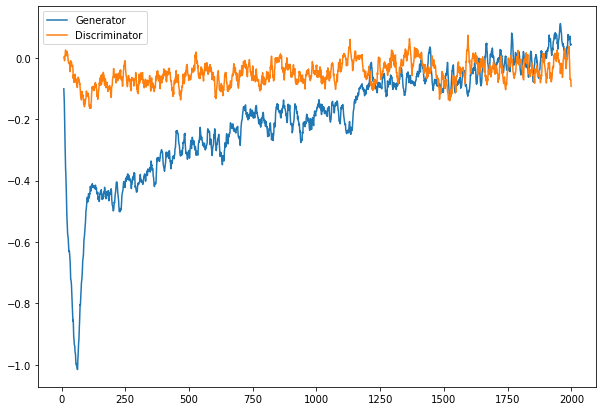

In [ ]:
logs = StringIO(str(output))
window = 10 # window size for the moving average, window=1 gets you the original series

df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# I think a regex would be better here
df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

plt.figure(figsize=(10,7))

# Plot with a moving average so it is less noisy
plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

plt.legend()
plt.show()

In [ ]:
model_ = train_gan[0]

In [ ]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x0,x1
count,10000.000000,10000.000000
mean,0.005215,-0.013349
std,0.992862,0.993240
min,-3.248325,-4.172570
25%,-0.665071,-0.682163
50%,0.003764,-0.016542
75%,0.678013,0.651074
max,4.062710,3.464564


In [ ]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3)))
sim_n

113

In [ ]:
## Function to analyze data from the sampled model 
def corr_power_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = m.sample(num_rows=sim_n).values
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    
    ## Extract the estimate and CI
    pval = res[1]
    r = res[0]
    tag = np.where(pval<0.05, 1, 0)
   
    # Return the estimate and the CI to the user
    out = pd.DataFrame({'r': [r], 'pval': [pval], 'tag': [tag]})
    return(out)


In [ ]:
x = model_.sample(num_rows=1000)

x.values.shape

(1000, 2)

In [ ]:
np.cov(x, rowvar=False) ** 0.5

array([[0.99693655, 0.50403328],
       [0.50403328, 0.99547849]])

In [ ]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(corr_power_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean 
gan_means = np.mean(gan_df, axis=0)

## Calculate the width of the confidence interval
gan_width = gan_means[2] - gan_means[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [gan_means[0]],
    'pvalue': [gan_means[1]],
    'power': [gan_means[2]]
})

gan_results



,runtime,correlation,pvalue,power
0,33.055602,0.256173,0.041528,0.812


In [ ]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [ ]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05], 
              'corr': np.arange(0.1, 0.5, 0.1), 
              'beta': [0.05, 0.1, 0.2, 0.3]}

param_df = expand_grid(dictionary)
param_df

,alpha,corr,beta
0,0.05,0.1,0.05
1,0.05,0.1,0.10
2,0.05,0.1,0.20
3,0.05,0.1,0.30
4,0.05,0.2,0.05
5,0.05,0.2,0.10
6,0.05,0.2,0.20
7,0.05,0.2,0.30
8,0.05,0.3,0.05
9,0.05,0.3,0.10


In [ ]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_corr_coef(alpha=param_df.loc[i, 'alpha'], 
                          correlation=param_df.loc[i, 'corr'],
                          beta=param_df.loc[i, 'beta'])
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','corr','beta','n_theory']
samp_size_theory_df

,alpha,corr,beta,n_theory
0,0.05,0.1,0.05,1294.0
1,0.05,0.1,0.10,1047.0
2,0.05,0.1,0.20,783.0
3,0.05,0.1,0.30,617.0
4,0.05,0.2,0.05,320.0
5,0.05,0.2,0.10,259.0
6,0.05,0.2,0.20,194.0
7,0.05,0.2,0.30,154.0
8,0.05,0.3,0.05,139.0
9,0.05,0.3,0.10,113.0


In [ ]:
########################
## 2) Sample Size for Power by Simulation from multivariate Distribution
########################

In [ ]:
def corr_power_samp_size(corr, n):
    
    ## Generate random data
    sigma_matrix = np.array([1,corr,corr,1]).reshape((2,2))
    mu_vec = np.array([0,0])
    dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    ## Analyze generated/simulated data
  
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')

    ## Extract the estimate and CI
    pval = res[1]
    r = res[0]
    tag = np.where(pval<0.05, 1, 0)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'corr': [r], 
                        'pval': [pval], 
                        'tag': [tag]})
    return(out)


In [ ]:
corr_power_samp_size(corr=0.3, n=113)

,corr,pval,tag
0,0.273894,0.00333,1


In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def corr_power_samp_size_sim( corr, n, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        sim_out.append(corr_power_samp_size(corr=corr, n=n))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array 
    sim_means = np.mean(sim_df, axis=0)

    ## Return expect width 
    return sim_means

In [ ]:
corr_power_samp_size_sim( corr=0.3, n=113,n_rep= 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

corr    0.298048
pval    0.021533
tag     0.898000
dtype: float64

In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, p, size, n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 10000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power_width = corr_power_samp_size_sim(n=int(float(samp_size_theory_df.loc[i, 'n_theory'])), 
                          corr= samp_size_theory_df.loc[i, 'corr'],
                          n_rep=n_rep)
    ## Round to largest integer
    power_width_ = str(np.round(power_width,4))
    ## Append sample size to list
    samp_size_sim_list.append(power_width_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','corr','beta','n_theory','power_width_sim']
samp_size_sim_df

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

,alpha,corr,beta,n_theory,power_width_sim
0,0.05,0.1,0.05,1294.0,corr 0.1000\npval 0.0107\ntag 0.9503...
1,0.05,0.1,0.10,1047.0,corr 0.0996\npval 0.0223\ntag 0.8946...
2,0.05,0.1,0.20,783.0,corr 0.0994\npval 0.0484\ntag 0.7973...
3,0.05,0.1,0.30,617.0,corr 0.0999\npval 0.0752\ntag 0.7006...
4,0.05,0.2,0.05,320.0,corr 0.1995\npval 0.0105\ntag 0.9501...
5,0.05,0.2,0.10,259.0,corr 0.1992\npval 0.0213\ntag 0.8999...
6,0.05,0.2,0.20,194.0,corr 0.1986\npval 0.0460\ntag 0.7951...
7,0.05,0.2,0.30,154.0,corr 0.1987\npval 0.0762\ntag 0.6991...
8,0.05,0.3,0.05,139.0,corr 0.2997\npval 0.0106\ntag 0.9510...
9,0.05,0.3,0.10,113.0,corr 0.3002\npval 0.0201\ntag 0.9095...


In [ ]:
## Timing for the simulation experiments
sim_time

445.7560303211212

In [ ]:
########################
## 3) Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution
########################

In [ ]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_corr(pop_n, pop_mu_vec, pop_sigma_matrix):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = scipy.stats.multivariate_normal.rvs(size=pop_n , mean=pop_mu_vec, cov=pop_sigma_matrix)
    ##
    #   ## Convert vector to pandas dataFrame
    # x_pd = pd.DataFrame({'x': x}) #need two column array 
    x_pd = pd.DataFrame(x, columns=['x0', 'x1'])

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=False, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out




In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def corr_power_samp_size_gan(pop_n, pop_mu_vec, pop_sigma_matrix, sim_n,n_rep):

    ## Get the learned GAN model --- after training 
    t0 = time()
    train_gan = train_gan_model_corr(pop_n=pop_n, pop_mu_vec=pop_mu_vec, pop_sigma_matrix=pop_sigma_matrix)
    t1 = time()
    fit_time = t1 - t0
    #fit_time
    
    ## Extract learned GAN model
    model_ = train_gan[0]

    ## Function to analyze data from the sampled model 
    def corr_power_samp_size_gan(m, sim_n):
        ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
        dat = m.sample(num_rows=sim_n).values
        ## Analyze generated/simulated data
        res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    
        ## Extract the estimate and CI
        pval = res[1]
        r = res[0]
        tag = np.where(pval<0.05, 1, 0)
   
        # Return the estimate and the CI to the user
        out = pd.DataFrame({'r': [r], 'pval': [pval], 'tag': [tag]})
        return(out)



    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []
 
    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(corr_power_samp_size_gan(m=model_, sim_n = sim_n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean 
    gan_means = np.mean(gan_df, axis=0)

    ## Return the GAN estimated power
    return gan_means

In [ ]:
##
## WARNING...notice very subtle difference between pop_n and sim_n
##
## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
##
## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
##     --- larger values can also substantially increase training time for the GAN model
##

t0 = time()
pop_n=1000
tmp = corr_power_samp_size_gan(pop_n= pop_n, 
                               pop_mu_vec= np.array([0,0]),
                               pop_sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2)),
                               sim_n=int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3))),
                               n_rep=1000)


t1 = time()

[tmp, t1-t0]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0.6683087354991897, 94.96991014480591]

In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power_width = corr_power_samp_size_gan(
                               pop_n= 1000, 
                               pop_mu_vec= np.array([0,0]),
                               pop_sigma_matrix = np.array([1,samp_size_theory_df.loc[i, 'corr'],samp_size_theory_df.loc[i, 'corr'],1]).reshape((2,2)),
                               sim_n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
                               n_rep=n_rep)
  
    ## Round to largest integer
    power_ = power_width[:,2]
    ## Append sample size to list
    samp_size_gan_list.append(power_)

t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','corr','beta','n_theory','power_width_gan']
samp_size_gan_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,corr,beta,n_theory,power_width_gan
0,0.05,0.1,0.05,1294.0,0.6445
1,0.05,0.1,0.10,1047.0,0.6445
2,0.05,0.1,0.20,783.0,0.6445
3,0.05,0.1,0.30,617.0,0.6445
4,0.05,0.2,0.05,320.0,0.6445
5,0.05,0.2,0.10,259.0,0.6445
6,0.05,0.2,0.20,194.0,0.6445
7,0.05,0.2,0.30,154.0,0.6445
8,0.05,0.3,0.05,139.0,0.6445
9,0.05,0.3,0.10,113.0,0.6445


In [ ]:
#gan_time

In [ ]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [ ]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-03-07'

In [ ]:
## Session Info
from sinfo import sinfo
sinfo()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
matplotlib  3.5.3
numpy       1.22.4
pandas      1.3.5
scipy       1.10.1
sdv         0.18.0
seaborn     0.11.2
sinfo       0.3.4
torch       1.13.1+cu116
tqdm        4.64.1
-----
IPython             7.9.0
jupyter_client      6.1.12
jupyter_core        5.2.0
notebook            6.3.0
-----
Python 3.8.10 (default, Nov 14 2022, 12:59:47) [GCC 9.4.0]
Linux-5.10.147+-x86_64-with-glibc2.29
2 logical CPU cores, x86_64
-----
Session information updated at 2023-03-07 16:57


In [ ]:
## Jupyter version
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.9.0
ipykernel        : 5.3.4
ipywidgets       : 7.7.1
jupyter_client   : 6.1.12
jupyter_core     : 5.2.0
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.7.2
nbconvert        : 6.5.4
nbformat         : 5.7.3
notebook         : 6.3.0
qtconsole        : not installed
traitlets        : 5.7.1


In [ ]:
## Python version
!python --version

Python 3.8.10
